# Data Extraction

The first step was to extract the data from the fukes ad convert them to Pandas Dataframes to have a more convenient way of dealing with it.

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from dtaidistance import dtw, ed
from dtaidistance import dtw_visualisation as dtwvis


We define some lists of common attributes, such as the time and the user_id of who is speaking, and some modality-specific features, ie. emotions, audio, and head gestures.  

In [31]:
columns_basic = [
    'timedelta', 'user_id', 'is_speaking'
]

columns_emotions = [
    'prob_face_anger', 'prob_face_contempt', 'prob_face_disgust', 'prob_face_fear',
    'prob_face_happiness', 'prob_face_neutral', 'prob_face_sadness', 'prob_face_surprise'
]

columns_audio = [
    'f0', 'intensity', 'jitter', 'log_energy',
    'mfcc_0', 'mfcc_1', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
    'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19',
    'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8',
    'mfcc_9', 'onset_strength', 'poly_features_0', 'poly_features_1',
    'shimmer', 'spectral_bandwidth', 'spectral_centroid',
    'spectral_contrast_0', 'spectral_contrast_1', 'spectral_contrast_2',
    'spectral_contrast_3', 'spectral_contrast_4', 'spectral_contrast_5',
    'spectral_contrast_6', 'spectral_flatness', 'spectral_rolloff',
    'zero_crossing_rate'
]

columns_head = [
    'gaze_on', 'nod_no', 'nod_yes', 'smile'
]


In [32]:
import numpy as np
import pandas as pd

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def handle_outliers(series, z_thresh=3):
    z_scores = (series - series.mean()) / series.std()
    return series[(z_scores < z_thresh) & (z_scores > -z_thresh)]

def prepare_for_comparison(_df, features):
    df = _df.copy()

    for feature in features:
        # Handle outliers
        df[feature] = handle_outliers(df[feature])
        
        # Z-score normalization
        df[feature] = (df[feature] - df[feature].mean()) / df[feature].std()
        
        # Interpolation to handle missing values
        df[feature] = df[feature].interpolate(limit_area=None, limit_direction='both')
        
        # Normalization to range [0, 1]
        df[feature] = normalize(df[feature].copy())
        
    return df

We then extract a DataFrame from each video, masking it based on the features it contains and replacing the hexadecimal user_ids with some human-readable names.

In [33]:
# data opening
videos = os.listdir('./videos/')

# surveys = []
features = []
full_dfs = []
audio_dfs = []
emotion_dfs = []
head_dfs = []

for video in videos:
    # f_survey = open(f'{video}/survey.csv', 'r')
    # surveys.append(pd.read_csv(f_survey))
    
    f_features = open(f'./videos/{video}/audio_video_features.csv', 'r')
    df = pd.read_csv(f_features)

    # make it more readable
    username1 = df['user_id'].unique()[0]
    username2 = df['user_id'].unique()[1]

    df['user_id'] = df['user_id'].replace(username1, "Bob")
    df['user_id'] = df['user_id'].replace(username2, "Joe")

    # append the datasets    
    full_dfs.append(df)
    audio_dfs.append(df[columns_basic + columns_audio])
    emotion_dfs.append(df[columns_basic + columns_emotions])
    head_dfs.append(df[columns_basic + columns_head])

The following function trims a given Dataframe removing all the rows in which the two persons are not both in the call: sometimes it might happen that one arrives after some minutes from the other one, and we want to discard all the time they are not both together and interacting.

In [34]:
import json
from datetime import timedelta
import math

# extract N time windows from the video
def trim(video, _df):
    """
        Masks the dataframe by the time both the speakers arrive
    """
    transcript = pd.read_csv(f'videos/{video}/transcription/transcript_cliffhanger.csv')
    i = 0
    start = 0

    # sometimes the first person to arrive speaks but there is nobody
    while True:
        start1 = math.floor(transcript['start'].values[i])
        start2 = math.floor(transcript['start'].values[i+1])
        
        # check if there is a response to the first utterance in less than 5s
        if start2-start1 < 5:
            start = start1
            break
        else:
            i+=1
    stop = math.ceil(transcript['stop'].values[-1])

    # mask the rows
    df = _df.copy()
    df['seconds'] = [pd.Timedelta(value).seconds for value in df['timedelta']]
    mask = (df['seconds'] >= start) & (df['seconds'] <= stop)
    selected_rows = df[mask]

    return selected_rows, start, stop


In [35]:
NWINDOWS = 2
WINDOW_SIZE = 3 * 60 # 3min in seconds
OFFSET_SIZE = 3 * 60 # 3min in seconds

def slice_in_windows(_df, start, stop):
    if NWINDOWS != 2:
        raise NotImplementedError

    df = _df.copy()
    
    # add offset - 3 minutes we dont want
    offset_mask = (df['seconds'] >= start+OFFSET_SIZE) & (df['seconds'] <= stop-OFFSET_SIZE)
    df = df[offset_mask]

    # then slice the offsetted(?)
    head = df[df['seconds']<=start+OFFSET_SIZE+WINDOW_SIZE]
    tail = df[df['seconds']>=stop-OFFSET_SIZE-WINDOW_SIZE]
    
    return head, tail


def slice_in_windows_v2(_df, start, stop):
    if NWINDOWS != 2:
        raise NotImplementedError

    df = _df.copy()
    # offset_mask = (df['seconds'] >= start+OFFSET_SIZE) & (df['seconds'] <= stop-OFFSET_SIZE)
    # df = df[offset_mask]
    
    bob_head = df[(df['user_id']=='Bob') & (df['is_speaking']==True)].head(WINDOW_SIZE)
    joe_head = df[(df['user_id']=='Joe') & (df['is_speaking']==True)].head(WINDOW_SIZE)
    bob_tail = df[(df['user_id']=='Bob') & (df['is_speaking']==True)].tail(WINDOW_SIZE)
    joe_tail = df[(df['user_id']=='Joe') & (df['is_speaking']==True)].tail(WINDOW_SIZE)

    return bob_head, joe_head, bob_tail, joe_tail


In [36]:
audio_features = ["f0", "intensity", "log_energy", "jitter", "shimmer"]
windows_audio = [] 
trimmed_audio = []

# for visualisation later
block1_features = audio_features[:3]
block2_features = audio_features[3:]

for i in range(len(audio_dfs)):
    trimmed, start, stop = trim(videos[i], audio_dfs[i])
    head, tail = slice_in_windows(trimmed, start, stop)
    head = prepare_for_comparison(head, audio_features)
    tail = prepare_for_comparison(tail, audio_features)
    trimmed = prepare_for_comparison(trimmed, audio_features)
    windows_audio.append({
        "head": head,
        "tail": tail
    })
    trimmed_audio.append(
        trimmed
    )

# Data Visualisation

Let's now take a look at the select features for what concerns audio:


In [37]:

def plot_audio_features(windows_audio, features, scatter=True, rolling=None):
    # head_joe_df = windows_audio['head']['joe'].copy()
    # head_bob_df = windows_audio['head']['bob'].copy()
    
    # tail_joe_df = windows_audio['tail']['joe'].copy()
    # tail_bob_df = windows_audio['tail']['bob'].copy()
    
    head_df = windows_audio['head']
    tail_df = windows_audio['tail']
    
    head_df_joe = head_df[head_df['user_id']=='Joe']
    head_df_bob = head_df[head_df['user_id']=='Bob']
    tail_df_joe = tail_df[tail_df['user_id']=='Joe']
    tail_df_bob = tail_df[tail_df['user_id']=='Bob']
    
    fig, axs = plt.subplots(len(features), 2, figsize=(15,15))


    bob_patch = mpatches.Patch(color='blue', label='Bob')
    joe_patch = mpatches.Patch(color='red', label='Joe')
    legend_patches = [bob_patch, joe_patch]

    bob_color = '#4747ad'
    joe_color = '#c72e2e'

    x_start = np.linspace(0, len(head_df), len(head_df))
    x_end = np.linspace(0, len(tail_df), len(tail_df))
    start_colors = [bob_color if user_id == 'Bob' else joe_color for user_id in head_df['user_id']]
    end_colors = [bob_color if user_id == 'Bob' else joe_color for user_id in tail_df['user_id']]


    for i in range(len(features)):
        feature = features[i]
        title = feature.replace('_', ' ').capitalize()

        # start
        if scatter:
            axs[i][0].scatter(head_df.index, head_df[feature], c=start_colors, alpha=0.8)
        else:
            axs[i][0].plot(head_df_joe.index, head_df_joe[feature], c=joe_color, alpha=0.8)
            axs[i][0].plot(head_df_bob.index, head_df_bob[feature], c=bob_color, alpha=0.8)

        if rolling:
            axs[i][0].plot(head_df_bob.index, head_df_bob[feature].rolling(rolling, min_periods=1).mean(), linewidth=3, c='b', alpha=0.95)
            axs[i][0].plot(head_df_joe.index, head_df_joe[feature].rolling(rolling, min_periods=1).mean(), linewidth=3, c='r', alpha=0.95)

        axs[i][0].set_title(f"{title} (start window)")
        axs[i][0].grid()
        axs[i][0].legend(handles=legend_patches)

        # end
        if scatter:
            axs[i][1].scatter(tail_df.index, tail_df[feature], c=end_colors, alpha=0.8)
        else:
            axs[i][1].plot(tail_df_joe.index, tail_df_joe[feature], c=joe_color, alpha=0.8)
            axs[i][1].plot(tail_df_bob.index, tail_df_bob[feature], c=bob_color, alpha=0.8)

        if rolling:
            axs[i][1].plot(tail_df_bob.index, tail_df_bob[feature].rolling(rolling, min_periods=1).mean(), linewidth=3, c='b', alpha=0.95)
            axs[i][1].plot(tail_df_joe.index, tail_df_joe[feature].rolling(rolling, min_periods=1).mean(), linewidth=3, c='r', alpha=0.95)

        axs[i][1].set_title(f"{title} (end window)")
        axs[i][1].grid()
        axs[i][1].legend(handles=legend_patches)
    

## Video #44

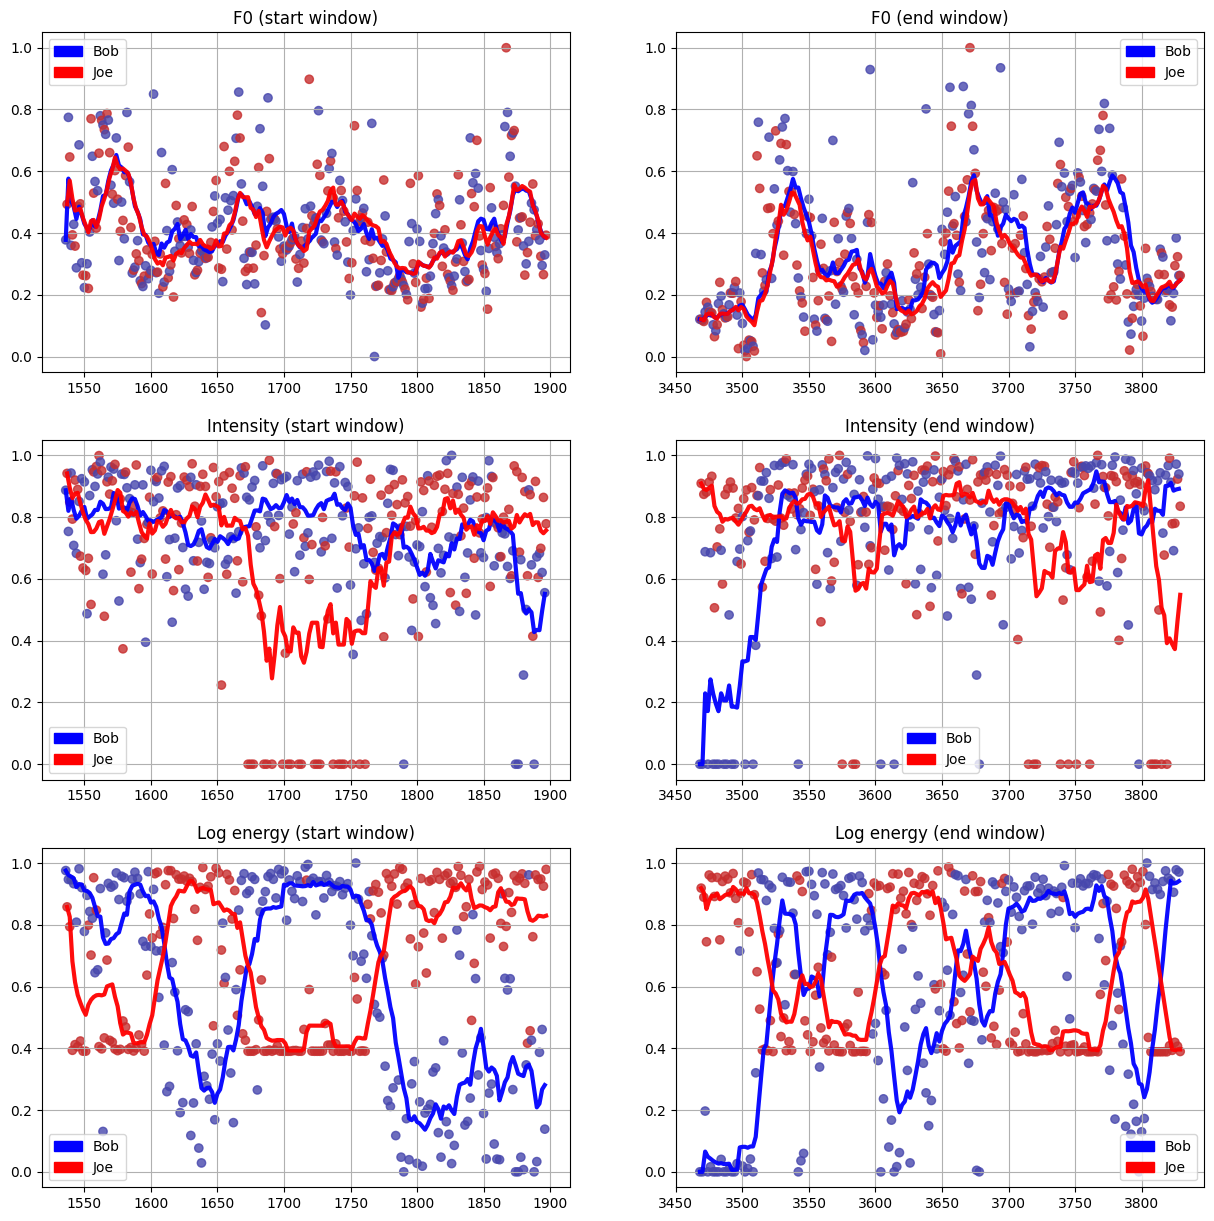

In [38]:
plot_audio_features(windows_audio[44], block1_features, scatter=True, rolling=10)

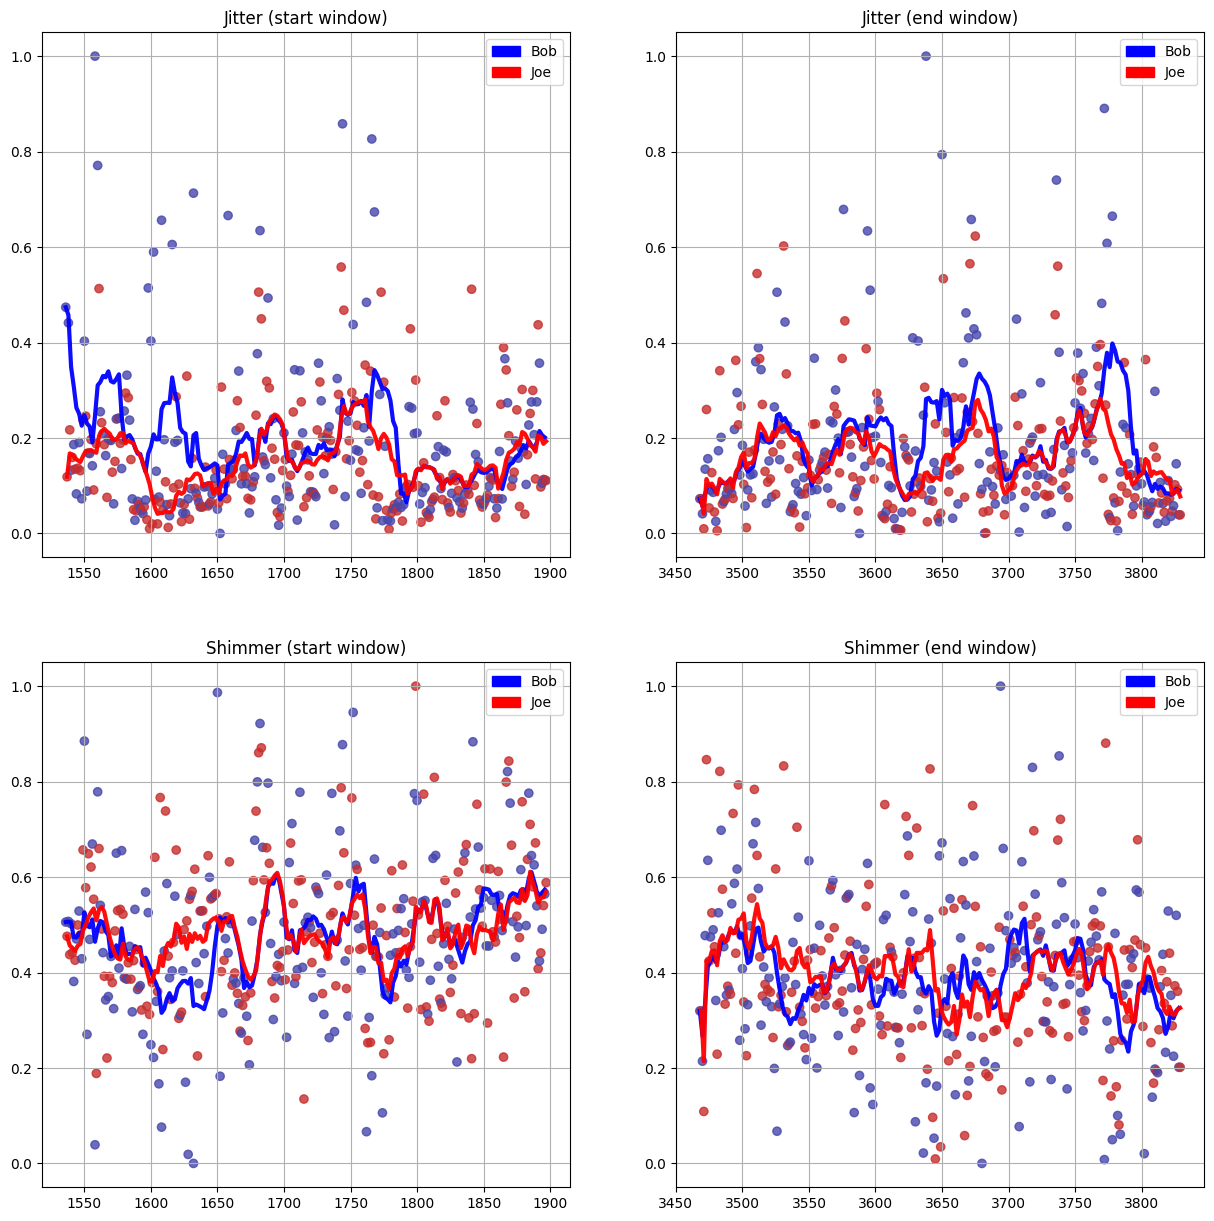

In [39]:
plot_audio_features(windows_audio[44], block2_features, scatter=True, rolling=10)

## first analysis

In [40]:
a = results.reset_index()
a[a['feature']=='f0']['start_diff'].values

array([0.11483317, 0.08553074, 0.1305138 , 0.03850257, 0.005986  ,
       0.00975231, 0.07999663, 0.18915743, 0.05596401, 0.06429759,
       0.02946405, 0.02541964, 0.04610851, 0.02159114, 0.06393584,
       0.01757015, 0.01634001, 0.07229524, 0.07685829, 0.07267567,
       0.09793379, 0.01214744, 0.06864249, 0.03345062, 0.0057447 ,
       0.03694439, 0.11446493, 0.12828416, 0.0002935 , 0.05680557,
       0.10518982, 0.15106891, 0.02373992, 0.01206801, 0.04443266,
       0.02072914, 0.04398209, 0.00229437, 0.00210057, 0.08067708,
       0.07262918, 0.07344313, 0.11717776, 0.1191439 , 0.00352795,
       0.02706549, 0.02036257, 0.06114052, 0.03967258, 0.04497216,
       0.00259449, 0.04955899, 0.08981729, 0.0687862 , 0.02293744,
       0.10939931, 0.04707207, 0.04760145, 0.0136997 ])

In [41]:
"""
    retrieve all the values of start_diff for each feature
    retrieve all the values of end_diff for each feature
    compare t test the two arrays
    and get a global significance measure
"""
global_alignment = {}
_results = results.reset_index()

for f in audio_features:
    global_alignment[f] = {} 
    f_start = _results[_results['feature']==f]['start_diff']
    f_end = _results[_results['feature']==f]['end_diff']
    # global_alignment[f]['start_mean'] = f_start.mean()
    # global_alignment[f]['end_mean'] = f_end.mean()
    global_alignment[f]['diff'] = f_start.mean() - f_end.mean()
    t, p = ttest_rel(f_start.values, f_end.values)
    global_alignment[f]['t'] = t
    global_alignment[f]['p'] = p

for k in global_alignment.keys():
    print(k)
    print(global_alignment[k]['p'])
    print(global_alignment[k]['diff'])
    print('')

f0
0.17371545155680976
0.0048554667529436615

intensity
0.17273420813362475
-0.010326560209306612

log_energy
0.018354626858270398
-0.03334100948603515

jitter
0.48726202574149735
0.0020114271741805793

shimmer
0.7471059569408353
-0.0008335936663376696



In [42]:
filtered = results[results['p_value']<0.05]
filtered[filtered['start_diff']>filtered['end_diff']].groupby('feature').size()
filtered.groupby('feature').size()

feature
f0            12
intensity     17
jitter         7
log_energy    27
shimmer        7
dtype: int64

## second analysis

In [43]:
# iterate thru videos
    # save user ids 
    # check in how many videos they repeat

data = []
for video in videos:
    _data = []
    f_features = open(f'./videos/{video}/audio_video_features.csv', 'r')
    df = pd.read_csv(f_features)

    # make it more readable
    username1 = df['user_id'].unique()[0] # bob
    username2 = df['user_id'].unique()[1] # joe
    idx = videos.index(video)

    _data.append(idx)
    _data.append(video)
    _data.append(username1)
    _data.append(username2)
    data.append(_data)

users_df = pd.DataFrame(data, columns=['video_idx', 'video', 'username_bob', 'username_joe'])
users_df.head()

,video_idx,video,username_bob,username_joe
0,0,01a4c01c-cf0e-4f37-ab2b-641bb604af30,5e6cade3d92ffb26677dbd84,5f1b2282a3103e2caff2fd7b
1,1,024c9be7-c98d-4a2e-b4a9-7884d0b0f626,5cc93712f2915d00148a0602,5f4d92a4584ab6064be44ce5
2,2,08fed9d5-6213-4742-94de-64a879fdf28c,5be76781f6d13b0001cf5257,5f26523b9e04df29fc462ea6
3,3,14e34c4e-4e27-42d8-928f-ad4a71f80764,5c7e91c1973c990016ea72b0,5eb9af967fbf4b0d17bbe946
4,4,1a19835c-4dd1-4d29-b945-e0b25285a26a,5ed1e0f7ba6548028fc64722,5f641cfa0c8b8b19b424aa4d


In [44]:
RANDOM_PEOPLE_NUM = 1
data = []

for video in videos:
    for feature in audio_features:
        video_idx = videos.index(video)

        # get bob and joe feature distribution
        current_video = trimmed_audio[video_idx]
        bob = current_video[current_video['user_id']=='Bob'][feature]
        joe = current_video[current_video['user_id']=='Joe'][feature]

        bob_userid = users_df.iloc[video_idx]['username_bob']
        joe_userid = users_df.iloc[video_idx]['username_joe']

        # find people to compare bob to and average their distributions
        non_partners_videos = users_df[(users_df['username_bob'] != bob_userid) & (users_df['username_joe'] != bob_userid) \
                                       & (users_df['username_bob'] != joe_userid) & (users_df['username_joe'] != joe_userid)]['video_idx'].values
        non_partners = []
        for _video in non_partners_videos:
            comp_video = trimmed_audio[_video]
            person = comp_video[comp_video['user_id']=='Bob'][feature]
            non_partners.append(person)
        non_partners = pd.concat(non_partners)

        # get bob and joe alignment difference with mean/std
        bob_joe_alignment = abs(bob.mean() - joe.mean())

        # compare them against the random people
        bob_others_alignment = abs(bob.mean() - non_partners.mean())
        joe_others_alignment = abs(joe.mean() - non_partners.mean())


        data.append([video_idx, feature, bob_joe_alignment, bob_others_alignment, joe_others_alignment])

df = pd.DataFrame(data, columns=['video_idx', 'feature', 'bob and joe', 'bob et al', 'joe et al' ])
df


,video_idx,feature,bob and joe,bob et al,joe et al
0,0,f0,0.070020,0.000479,0.070499
1,0,intensity,0.059868,0.019616,0.079485
2,0,log_energy,0.126450,0.029721,0.096728
3,0,jitter,0.008740,0.041968,0.033228
4,0,shimmer,0.005279,0.009802,0.015081
...,...,...,...,...,...
290,58,f0,0.000690,0.106925,0.107615
291,58,intensity,0.078295,0.068221,0.010074
292,58,log_energy,0.155941,0.000618,0.156558
293,58,jitter,0.000768,0.008200,0.008968


In [45]:
global_alignment = {}

for f in audio_features:
    global_alignment[f] = {} 
    f_start = df[df['feature']==f]['bob and joe']
    f_end1 =  df[df['feature']==f]['bob et al']
    f_end2 =  df[df['feature']==f]['joe et al']
    _, p1 = ttest_rel(f_start.values, f_end1.values) 
    _, p2 = ttest_rel(f_start.values, f_end2.values)
    global_alignment[f]['p_bob_vs_random'] = str(p1)
    global_alignment[f]['p_joe_vs_random'] = str(p2)
    global_alignment[f]['diff_bob_vs_random'] = f_end1.mean() - f_start.mean()
    global_alignment[f]['diff_joe_vs_random'] = f_end2.mean() - f_start.mean()
 

for k in global_alignment.keys():
    print(f"{k} p_bob_vs_random {global_alignment[k]['p_bob_vs_random']}")
    print(f"{k} p_joe_vs_random {global_alignment[k]['p_joe_vs_random']}")
    print(f"{k} diff_bob_vs_random {global_alignment[k]['diff_bob_vs_random']}")
    print(f"{k} diff_joe_vs_random {global_alignment[k]['diff_joe_vs_random']}")
    print()

f0 p_bob_vs_random 0.0918203738155835
f0 p_joe_vs_random 0.0613102311947208
f0 diff_bob_vs_random 0.011740062730724116
f0 diff_joe_vs_random 0.013687423420225331

intensity p_bob_vs_random 0.003994191291445899
intensity p_joe_vs_random 6.716221771239472e-05
intensity diff_bob_vs_random -0.037253889517004125
intensity diff_joe_vs_random -0.026540334531952876

log_energy p_bob_vs_random 0.002439628654166787
log_energy p_joe_vs_random 0.014725816146234551
log_energy diff_bob_vs_random -0.04123753180931194
log_energy diff_joe_vs_random -0.019943334201789772

jitter p_bob_vs_random 0.0001376786545919425
jitter p_joe_vs_random 2.0066176009091254e-05
jitter diff_bob_vs_random 0.011916988333688518
jitter diff_joe_vs_random 0.012516898984219593

shimmer p_bob_vs_random 1.2065191322742365e-05
shimmer p_joe_vs_random 1.3495770622462043e-05
shimmer diff_bob_vs_random 0.016865998187949358
shimmer diff_joe_vs_random 0.016349459973007956



## third analysis

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def summarize_and_test(df, features, user_col='user_id'):
    summary_results = {}

    for feature in features:
        user1_data = df[df[user_col] == 'Joe'][feature]
        user2_data = df[df[user_col] == 'Bob'][feature]
        
        # Calculate means and standard deviations
        mean_user1 = user1_data.mean()
        std_user1 = user1_data.std()
        mean_user2 = user2_data.mean()
        std_user2 = user2_data.std()
        
        # Perform t-test
        t_stat, p_value = ttest_rel(user1_data, user2_data)
        
        summary_results[feature] = {
            'mean_Joe': mean_user1,
            'std_Joe': std_user1,
            'mean_Bob': mean_user2,
            'std_Bob': std_user2,
            't_stat': t_stat,
            'p_value': p_value
        }
    
    return pd.DataFrame.from_dict(summary_results, orient='index')


In [47]:
from scipy.stats import ttest_ind_from_stats, ttest_ind, ttest_rel, ttest_rel

def analyze_alignment(videos, dfs, features, user_col='user_id'):
    summary_results = []

    for video in videos:
        video_idx = videos.index(video)
        start_df = dfs[video_idx]['head']
        end_df = dfs[video_idx]['tail']
        
        for feature in features:
            # Get data for Joe and Bob at start and end
            start_joe = start_df[start_df[user_col] == 'Joe'][feature]
            start_bob = start_df[start_df[user_col] == 'Bob'][feature]
            end_joe = end_df[end_df[user_col] == 'Joe'][feature]
            end_bob = end_df[end_df[user_col] == 'Bob'][feature]

            # Calculate mean differences
            mean_start_diff = start_joe.mean() - start_bob.mean()
            mean_end_diff = end_joe.mean() - end_bob.mean()
            std_start_diff = start_joe.std() - start_bob.std()
            std_end_diff = start_joe.std() - start_bob.std()
            nobs_start = len(start_df)
            nobs_end = len(end_df)

            start = list(map(lambda a, b: a - b, start_bob.values, start_joe.values))
            end = list(map(lambda a, b: a - b, end_bob.values, end_joe.values))

            # Perform paired t-test on the differences
            #t_stat, p_value = ttest_ind_from_stats(mean_start_diff, std_start_diff, nobs_start, mean_end_diff, std_end_diff, nobs_end)
            t_stat, p_value = ttest_rel(start, end)
            print(p_value)
            summary_results.append((
                video_idx, feature, abs(mean_start_diff), abs(mean_end_diff), t_stat, p_value
            ))

    summary_df = pd.DataFrame(summary_results, columns=[
        'video_idx', 'feature', 'start_diff', 'end_diff', 't_stat', 'p_value'
    ])
    
    summary_df.set_index(['video_idx', 'feature'], inplace=True)
    return summary_df

# Assuming videos is a list of video identifiers and dfs is a corresponding list of dataframes with 'head' and 'tail' keys
# features = ['f0', 'intensity', 'log_energy', 'shimmer', 'jitter']
# result_df = analyze_alignment(videos, dfs, features)


In [48]:
results = analyze_alignment(videos, windows_audio, audio_features)
results.to_csv('tantivideo.csv')
results

0.20062039198343845
0.36007379602104705
0.09387909686141477
0.7039830478032714
0.7183709643563279
0.17538065695556354
0.40413886940390276
0.2374728865192822
0.26212447490703733
0.5936713740959174
0.7205526332600267
0.006702879592806602
0.009256066483246936
0.05734824661556489
0.46816007586181396
0.3175056680951291
1.5924115700394657e-07
0.287102657022252
0.18832818795425113
0.3376970770500157
0.9266606756829807
0.21825486093350485
1.4337550573475259e-05
0.4065481153532092
0.4667302162761515
0.10575605132980118
0.04291894688320583
0.2853409753954802
0.7650202951993754
0.3997978729821732
0.9908168460485092
0.7650994564130724
0.06065259297444871
0.8792278957290462
0.830910441211635
0.23758069630325285
0.343240568709245
0.011426136462883638
0.45727346661892443
0.6323044324740339
0.781567628555511
0.0014588760604705518
3.1963148544154575e-11
0.6373215525822784
0.07721200074997235
0.447072725614474
0.015828806122168432
0.07667135913775515
0.0037557573584382736
0.12480149216329746
0.849679619

start_diff  end_diff    t_stat   p_value
video_idx feature                                             
0         f0            0.114833  0.087027  1.284492  0.200620
          intensity     0.096180  0.066943  0.917566  0.360074
          log_energy    0.241184  0.133454 -1.684185  0.093879
          jitter        0.014242  0.007756 -0.380554  0.703983
          shimmer       0.027979  0.021722 -0.361203  0.718371
...                          ...       ...       ...       ...
58        f0            0.013700  0.001912  0.771427  0.441465
          intensity     0.048999  0.094700  1.394021  0.165030
          log_energy    0.047110  0.106345  1.344266  0.180554
          jitter        0.012632  0.000455 -0.687932  0.492381
          shimmer       0.001320  0.002001 -0.042617  0.966054

[295 rows x 4 columns]

In [49]:
results[results['p_value']<0.05].groupby('feature').size()

feature
f0            12
intensity     17
jitter         7
log_energy    27
shimmer        7
dtype: int64

In [50]:
results.groupby('feature').size()


feature
f0            59
intensity     59
jitter        59
log_energy    59
shimmer       59
dtype: int64

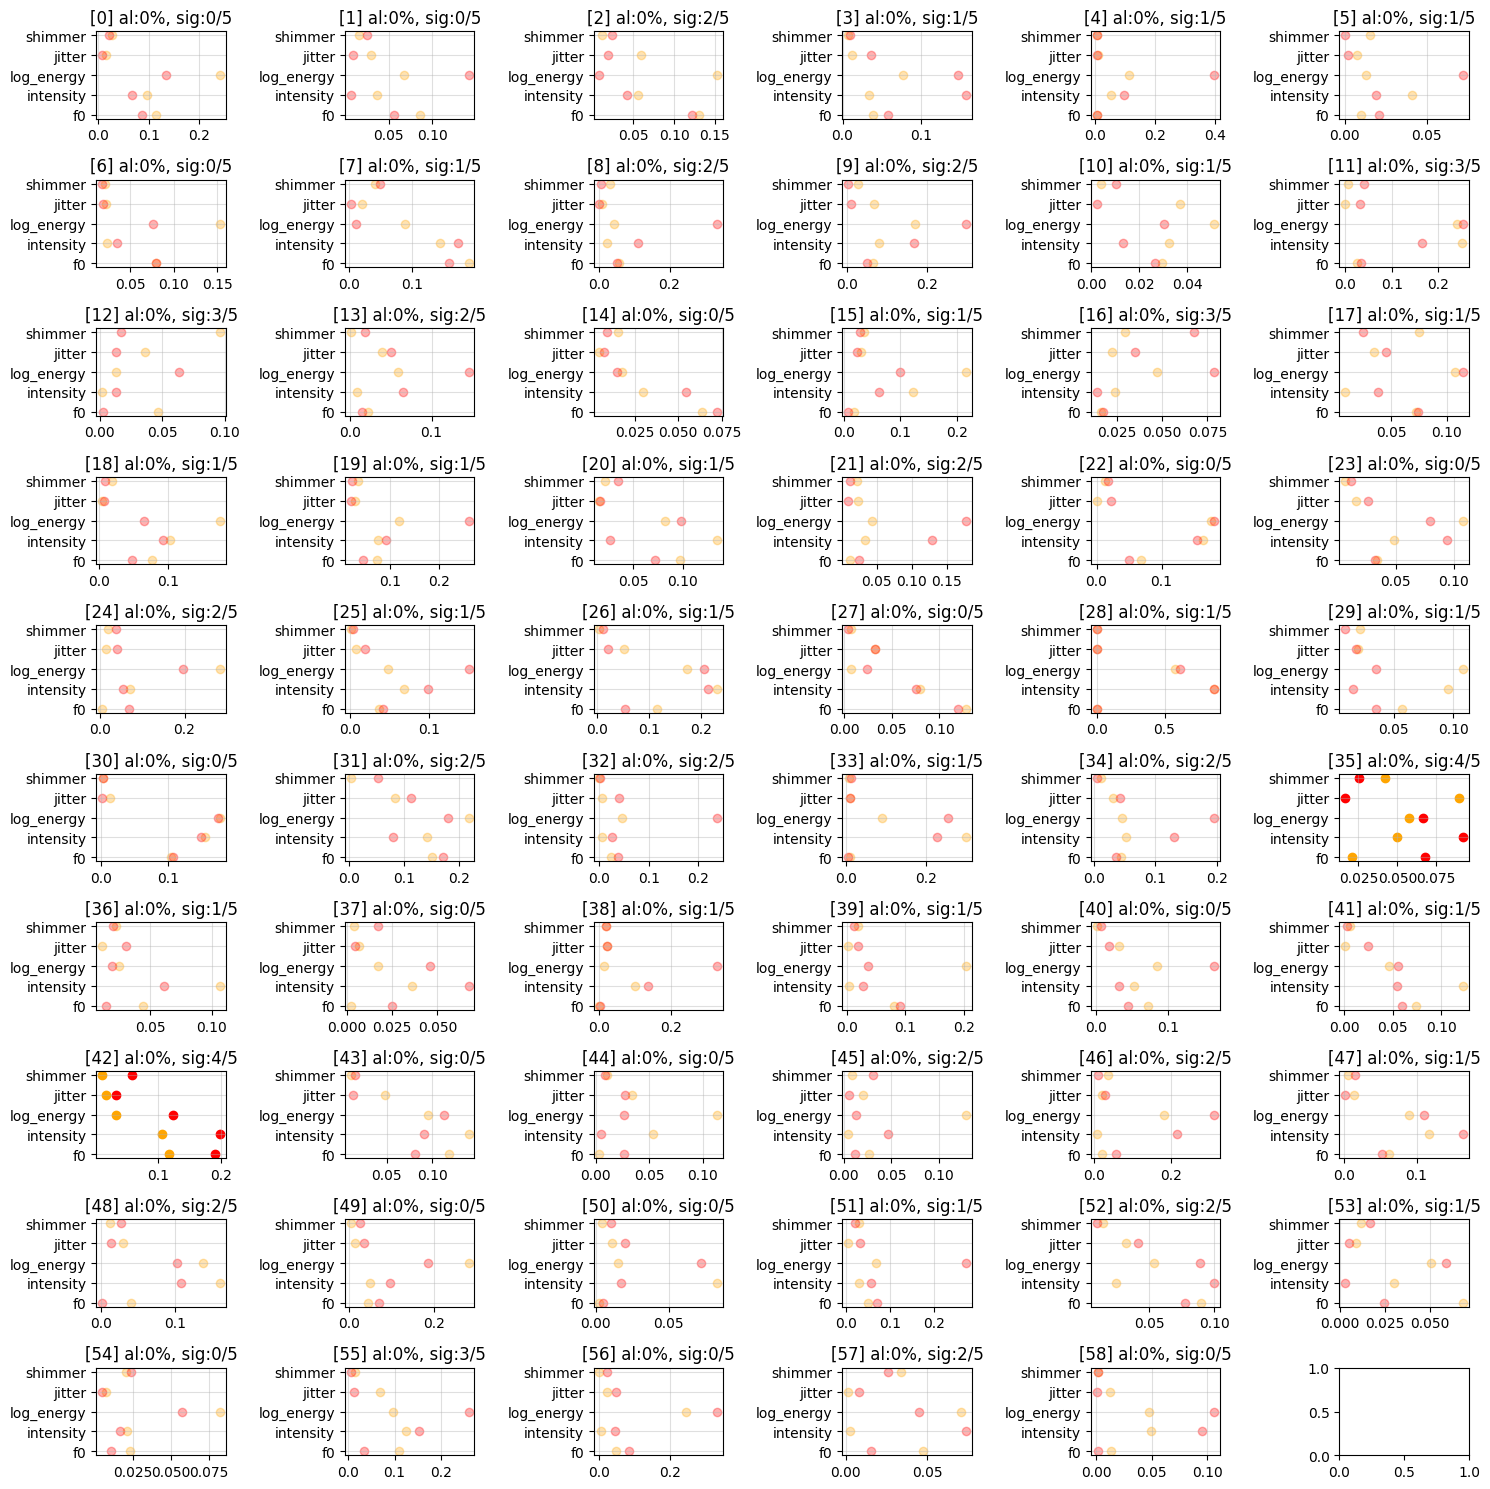

In [51]:
num_videos = 59
import matplotlib.pyplot as plt

# Set the figure size
fig, axs = plt.subplots(10, 6, figsize=(15, 15))
SIGNIFICANT_THRESHOLD = 4

# Flatten the axs array
axs = axs.flatten()
start_patch = mpatches.Patch(color='orange', label='Start')
end_patch = mpatches.Patch(color='red', label='End')
legend_patches = [start_patch, end_patch]

# Iterate over each video's features
for i in range(num_videos):
    video_features = results.loc[i]
    
    # Get the start and end diff for each feature
    start_diff = video_features['start_diff']
    end_diff = video_features['end_diff']
    
    feature_labels = ['f0', 'intensity', 'log_energy', 'jitter', 'shimmer']
    significant_features = len(video_features[video_features['p_value']<0.05])
    significance = significant_features # >= SIGNIFICANT_THRESHOLD
    
    alignment = 0.0
    for f in feature_labels:
        start = video_features.loc[f]['start_diff']
        end = video_features.loc[f]['end_diff']
        
        results.loc[i, f'alignment_{f}'] = 1 if end < start else 0    

    # Create a scatter plot for each feature
    axs[i].scatter(start_diff, feature_labels, c='orange', alpha=1.0 if significance>=SIGNIFICANT_THRESHOLD else 0.3)
    axs[i].scatter(end_diff, feature_labels, c='r', alpha=1.0 if significance>=SIGNIFICANT_THRESHOLD else 0.3)
    
    # Set the title for each subplot
    axs[i].set_title(f'[{i}] al:{math.floor(alignment*100)}%, sig:{significance}/5')
    axs[i].grid(alpha=0.4)
    

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot

plt.show()

# ORANGE IS START, RED IS END

In [52]:
results[(results['p_value']<0.05) & (results['start_diff'] > results['end_diff'])].groupby('feature').size()

feature
f0            8
intensity     7
jitter        5
log_energy    7
shimmer       3
dtype: int64